<div align=center>

<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
<font color=#4d7db8>
Sharif University of Technology - Department of Electrical Engineering
</font>
<p></p>
<font color=#4d7db8>
Introduction To Machine Learning - Dr. Sajjad Amini
</font>
<br/>
<br/>
Spring Semester 1401-02

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Project - 3rd Phase
<br />
Image Super Resolution using Autoencoder
			</font>
    <br/>
<font size=4>
			<br/><br/>
Due on Tir 10th
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=green>
Should you have any questions concerning the project, please feel free to ask via Telegram.
     </font>
</font>
                <br/>
    </div>

# Personal Info
<hr/>
    <div class="column" align=center>
    <font size=4>
        <div class="column">
        <br />
            student_number = Stu. No. 1
            <br />
            Name = ...   
            <br />
            Last_Name = ...
        </div>
        <div class="column">
        <br />
            student_number = Stu. No. 2
            <br />
            Name = ...   
            <br />
            Last_Name = ...
        </div>
    </font>
    </div>


1. Download the "image super resolution (from unsplash)" dataset and split it's validation set to new validation set and test set.
2. Design and train an AutoEncoder using `PyTorch` (not `TensorFlow`) on the dataset to enhance the resolution of images from low resolution to high resolution.
3. plot learning curve and visualize low resolution images of test set, their corresponding high resolution images and their reconstructed versions side by side.

# Import Necessary Libraries

In [ ]:
import gc
gc.collect()

!kill -9 -1

In [12]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [13]:
import torch
import numpy as np
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from matplotlib import pyplot as plt
from typing import Dict
import os
from glob import glob
import cv2
from PIL import Image
import math
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

# Load Dataset and Prepare It

In [40]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class ImageDataset(Dataset):
    def __init__(self, scale=4, type='train'):

        assert type in {'train','test'}
        self.type = type
        if type == 'train':
            self.train_hr_path = './DIV2K/DIV2K/DIV2K_train_HR/'
            self.train_lr_path = './DIV2K/DIV2K/DIV2K_train_LR_bicubic/'+f'X{scale}/'
            self.files = list(zip([self.train_hr_path+str for str in os.listdir(self.train_hr_path)],[self.train_lr_path+str for str in os.listdir(self.train_lr_path)]))
        else:
            self.test_hr_path = './DIV2K/DIV2K/DIV2K_test_HR/'
            self.test_lr_path = './DIV2K/DIV2K/DIV2K_test_LR_bicubic/'+f'X{scale}/'
            self.files = list(zip([self.test_hr_path+str for str in os.listdir(self.test_hr_path)],[self.test_lr_path+str for str in os.listdir(self.test_lr_path)]))

        # Transforms for low resolution images and high resolution images
        hr_height, hr_width = (256,340)
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_width // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_width), Image.BICUBIC),
                transforms.ToTensor(),
            ]
        )

    def __getitem__(self, index):
        hr_path, lr_path = self.files[index]
        img_hr = self.hr_transform(Image.open(hr_path))
        img_lr = self.lr_transform(Image.open(lr_path))
        return (img_lr, img_hr)

    def __len__(self):
        return len(self.files)

In [41]:
batch_size = 32
train_set = ImageDataset(scale=4,type='train')
test_set = ImageDataset(scale=4,type='test')
trainLoader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
testLoader = DataLoader(test_set,batch_size=1,shuffle=True)

# Define Your Model
torch neural network model

In [42]:
class ConvolutionalBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, batch_norm=False, activation=None):
        super(ConvolutionalBlock, self).__init__()

        if activation is not None:
            activation = activation.lower()
            assert activation in {'prelu', 'leakyrelu', 'tanh'}
        layers = list()
        layers.append(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2))

        if batch_norm is True:
            layers.append(nn.BatchNorm2d(num_features=out_channels))
        if activation == 'prelu':
            layers.append(nn.PReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU(0.2))
        elif activation == 'tanh':
            layers.append(nn.Tanh())

        self.conv_block = nn.Sequential(*layers)

    def forward(self, input):
        output = self.conv_block(input)  # (N, out_channels, w, h)

        return output


class SubPixelConvolutionalBlock(nn.Module):

    def __init__(self, kernel_size=3, n_channels=64, scaling_factor=2):

        super(SubPixelConvolutionalBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels=n_channels, out_channels=n_channels * (scaling_factor ** 2),
                              kernel_size=kernel_size, padding=kernel_size // 2)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=scaling_factor)
        self.prelu = nn.PReLU()

    def forward(self, input):
        output = self.conv(input)  # (N, n_channels * scaling factor^2, w, h)
        output = self.pixel_shuffle(output)  # (N, n_channels, w * scaling factor, h * scaling factor)
        output = self.prelu(output)  # (N, n_channels, w * scaling factor, h * scaling factor)

        return output


class ResidualBlock(nn.Module):

    def __init__(self, kernel_size=3, n_channels=64):

        super(ResidualBlock, self).__init__()

        self.conv_block1 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation='PReLu')

        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size,
                                              batch_norm=True, activation=None)

    def forward(self, input):

        residual = input  # (N, n_channels, w, h)
        output = self.conv_block1(input)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)

        return output


class SRResNet(nn.Module):

    def __init__(self, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=4):

        super(SRResNet, self).__init__()

        scaling_factor = int(scaling_factor)
        assert scaling_factor in {2, 4, 8}, "The scaling factor must be 2, 4, or 8!"

        # The first convolutional block
        self.conv_block1 = ConvolutionalBlock(in_channels=3, out_channels=n_channels, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='PReLu')

        # A sequence of n_blocks residual blocks, each containing a skip-connection across the block
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(kernel_size=small_kernel_size, n_channels=n_channels) for i in range(n_blocks)])

        # Another convolutional block
        self.conv_block2 = ConvolutionalBlock(in_channels=n_channels, out_channels=n_channels,
                                              kernel_size=small_kernel_size,
                                              batch_norm=True, activation=None)

        # Upscaling is done by sub-pixel convolution, with each such block upscaling by a factor of 2
        n_subpixel_convolution_blocks = int(math.log2(scaling_factor))
        self.subpixel_convolutional_blocks = nn.Sequential(
            *[SubPixelConvolutionalBlock(kernel_size=small_kernel_size, n_channels=n_channels, scaling_factor=2) for i
              in range(n_subpixel_convolution_blocks)])

        # The last convolutional block
        self.conv_block3 = ConvolutionalBlock(in_channels=n_channels, out_channels=3, kernel_size=large_kernel_size,
                                              batch_norm=False, activation='Tanh')

    def forward(self, lr_imgs):
        output = self.conv_block1(lr_imgs)  # (N, 3, w, h)
        residual = output  # (N, n_channels, w, h)
        output = self.residual_blocks(output)  # (N, n_channels, w, h)
        output = self.conv_block2(output)  # (N, n_channels, w, h)
        output = output + residual  # (N, n_channels, w, h)
        output = self.subpixel_convolutional_blocks(output)  # (N, n_channels, w * scaling factor, h * scaling factor)
        sr_imgs = self.conv_block3(output)  # (N, 3, w * scaling factor, h * scaling factor)
        return sr_imgs


# Fit The Model
Also Define optimizer, Criterion and other parameters

In [43]:
lr = 0.0001
epoch_nums = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SRResNet(scaling_factor=4,n_blocks=8).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
for epoch in range(epoch_nums):  # loop over the dataset multiple times

    running_loss = 0.0
    tqdm_bar = tqdm(trainLoader, desc=f'Training Epoch {epoch} ', total=int(len(trainLoader)))
    for i, imgs in enumerate(tqdm_bar):
        ## FILL HERE
        ## You should train the model and also print the running loss for each batch
        lr, hr = imgs
        lr = lr.to(device)
        hr = hr.to(device)
        sr = model(lr)
        loss = criterion(sr, hr)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    running_loss /= batch_size
    print('epoch : ',epoch,', loss : ',running_loss)
print('Finished Training')


Training Epoch 0 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  0 , loss :  0.03868720983155072


Training Epoch 1 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  1 , loss :  0.023669610964134336


Training Epoch 2 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  2 , loss :  0.022100381087511778


Training Epoch 3 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  3 , loss :  0.02167469821870327


Training Epoch 4 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  4 , loss :  0.021373091731220484


Training Epoch 5 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  5 , loss :  0.02103458042256534


Training Epoch 6 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  6 , loss :  0.021096357610076666


Training Epoch 7 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  7 , loss :  0.02076386846601963


Training Epoch 8 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  8 , loss :  0.020563958678394556


Training Epoch 9 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  9 , loss :  0.02060775994323194


Training Epoch 10 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  10 , loss :  0.020730453543365


Training Epoch 11 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  11 , loss :  0.020641602342948318


Training Epoch 12 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  12 , loss :  0.020504832733422518


Training Epoch 13 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  13 , loss :  0.020427949260920286


Training Epoch 14 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  14 , loss :  0.020281474106013775


Training Epoch 15 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  15 , loss :  0.020496137673035264


Training Epoch 16 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  16 , loss :  0.020340322982519865


Training Epoch 17 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  17 , loss :  0.020656099542975426


Training Epoch 18 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  18 , loss :  0.020424873800948262


Training Epoch 19 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  19 , loss :  0.020550965564325452


Training Epoch 20 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  20 , loss :  0.020173581666313112


Training Epoch 21 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  21 , loss :  0.020420602755621076


Training Epoch 22 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  22 , loss :  0.02029160037636757


Training Epoch 23 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  23 , loss :  0.020159143023192883


Training Epoch 24 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  24 , loss :  0.020216427044942975


Training Epoch 25 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  25 , loss :  0.020327557111158967


Training Epoch 26 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  26 , loss :  0.020006726728752255


Training Epoch 27 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  27 , loss :  0.020339678856544197


Training Epoch 28 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  28 , loss :  0.02033822750672698


Training Epoch 29 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  29 , loss :  0.020102030597627163


Training Epoch 30 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  30 , loss :  0.02027432108297944


Training Epoch 31 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  31 , loss :  0.019762840354815125


Training Epoch 32 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  32 , loss :  0.01995688327588141


Training Epoch 33 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  33 , loss :  0.019811228616163135


Training Epoch 34 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  34 , loss :  0.019999232375994325


Training Epoch 35 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  35 , loss :  0.019592132535763085


Training Epoch 36 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  36 , loss :  0.01996321906335652


Training Epoch 37 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  37 , loss :  0.01967800920829177


Training Epoch 38 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  38 , loss :  0.019736869726330042


Training Epoch 39 :   0%|          | 0/9 [00:00<?, ?it/s]

epoch :  39 , loss :  0.019277866929769516
Finished Training


In [46]:
# save model
torch.save(model.state_dict(), '/content/drive/MyDrive/sp_model.pth')

# Plot The Results

In [20]:
# load model
model = SRResNet(scaling_factor=4,n_blocks=8)
model.load_state_dict(torch.load('/content/drive/MyDrive/sp_model.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.MSELoss().to(device)

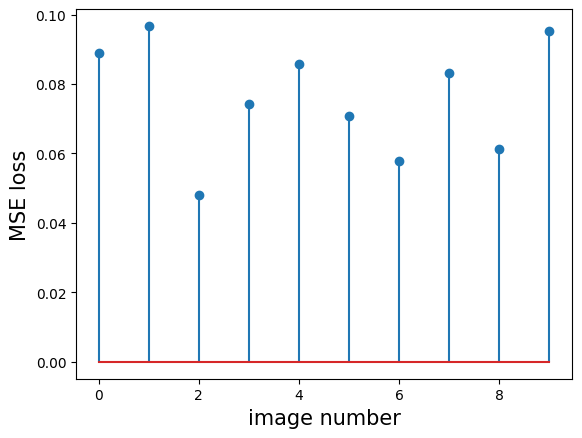

In [52]:
losses = []
low_res_images = []
super_res_images = []
high_res_images = []
with torch.no_grad():
    for i, imgs in enumerate(testLoader):
        lr, hr = imgs
        lr = lr.to(device)
        hr = hr.to(device)
        sr = model(lr)
        loss = criterion(sr, hr)
        losses.append(loss.item())
        super_res_images.append(np.array(torch.squeeze(hr.cpu(),dim=0)))
        low_res_images.append(np.array(torch.squeeze(lr.cpu(),dim=0)))
        high_res_images.append(np.array(torch.squeeze(hr.cpu(),dim=0)))

super_res_images = np.array(super_res_images)
low_res_images = np.array(low_res_images)
high_res_images = np.array(high_res_images)

plt.figure()
plt.stem(losses)
plt.xlabel('image number',fontsize=15)
plt.ylabel('MSE loss',fontsize=15)
plt.show()

In [53]:
outputs_low = low_res_images.transpose((0,2,3,1))
outputs_super = super_res_images.transpose((0,2,3,1))
outputs_high = high_res_images.transpose((0,2,3,1))
plt.figure(figsize=(20,40))
for i in range(0,10):
    plt.subplot(10,3,3*i+1)
    plt.imshow(outputs_low[i])
    plt.subplot(10,3,3*i+2)
    plt.imshow(outputs_super[i])
    plt.subplot(10,3,3*i+3)
    plt.imshow(outputs_high[i])

plt.show()

Output hidden; open in https://colab.research.google.com to view.